In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
#%pip install missingno
#import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
#from scipy.stats import norm
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import scipy
#import scipy.stats as stats
#from scipy.stats import skew,boxcox_normmax, zscore
#from scipy.special import boxcox1p
#from scipy.stats import boxcox
#from scipy.stats import boxcox_normmax

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [12]:
def load_train():
    data = pd.read_csv("../research/datasets/train.csv")
    return data

def load_test():
    data = pd.read_csv("../research/datasets/test.csv")
    return data

In [13]:
df_train = load_train()
df_test = load_test()

C:\Users\BORA\AppData\Local\Temp\ipykernel_1564\904664411.py:2: DtypeWarning: Columns (13,15,19,30,32,37,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../research/datasets/train.csv")


In [22]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(10))
    print("##################### Tail #####################")
    print(dataframe.tail(10))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    #print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [23]:
check_df(df_train)

##################### Shape #####################
(65125, 44)
##################### Types #####################
Basvuru Yili                                                   int64
Degerlendirme Puani                                          float64
Cinsiyet                                                      object
Dogum Tarihi                                                  object
Dogum Yeri                                                    object
Ikametgah Sehri                                               object
Universite Adi                                                object
Universite Turu                                               object
Burslu ise Burs Yuzdesi                                      float64
Burs Aliyor mu?                                               object
Bölüm                                                         object
Universite Kacinci Sinif                                      object
Universite Not Ortalamasi                                   

In [24]:
check_df(df_test)

##################### Shape #####################
(11049, 43)
##################### Types #####################
Basvuru Yili                                                   int64
Cinsiyet                                                      object
Dogum Tarihi                                                  object
Dogum Yeri                                                    object
Ikametgah Sehri                                               object
Universite Adi                                                object
Universite Turu                                               object
Burslu ise Burs Yuzdesi                                      float64
Burs Aliyor mu?                                               object
Bölüm                                                         object
Universite Kacinci Sinif                                      object
Universite Not Ortalamasi                                     object
Daha Once Baska Bir Universiteden Mezun Olmus               

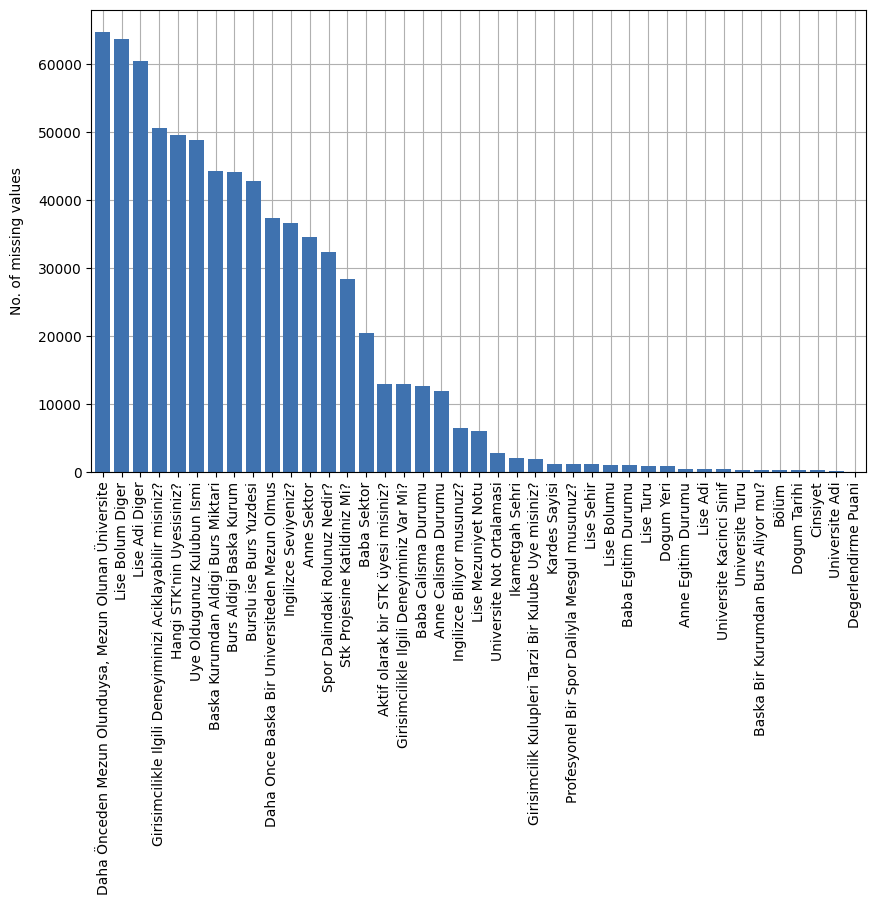

In [17]:
nans = df_train.isna().sum().sort_values(ascending=False)
nans = nans[nans > 0]
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.bar(nans.index, nans.values, zorder=2, color="#3f72af")
ax.set_ylabel("No. of missing values", labelpad=10)
ax.set_xlim(-0.6, len(nans) - 0.4)
ax.xaxis.set_tick_params(rotation=90)
plt.show()